In [1]:
import os
import polars as pl

df = pl.read_csv("./features_complete.csv")

from sklearn.preprocessing import StandardScaler

print(df)
scaler = StandardScaler()
name_df = df.clone()
df = df.select(
    pl.exclude("name")
)
df = pl.DataFrame(scaler.fit_transform(df))
data = df.to_numpy()
print(df)
print(df.std())
print(df.mean())

# weight
# df = df.with_columns(
#     column_74 = pl.col("column_74") * 3,
#     column_75 = pl.col("column_75") * 3,
# )

print(df)
print(df.std())
print(df.mean())


shape: (674, 77)
┌──────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬────────────┬───────────────┐
│ f1_min   ┆ f1_max   ┆ f1_std   ┆ f1_mean  ┆ … ┆ f19_max  ┆ f19_std  ┆ f19_mean   ┆ name          │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---        ┆ ---           │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64        ┆ str           │
╞══════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪════════════╪═══════════════╡
│ 0.940972 ┆ 0.972039 ┆ 0.007291 ┆ 0.955354 ┆ … ┆ 0.000487 ┆ 0.000049 ┆ 5.8271e-7  ┆ dance_data_19 │
│          ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆ 0_corrected   │
│ 1.00843  ┆ 1.023925 ┆ 0.001258 ┆ 1.023688 ┆ … ┆ 0.002367 ┆ 0.000216 ┆ 0.000003   ┆ dance_data_48 │
│          ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆ _corrected    │
│ 0.709254 ┆ 0.931043 ┆ 0.079408 ┆ 0.846652 ┆ … ┆ 0.000873 ┆ 0.000219 ┆ 0.

[[  28.          203.            0.            2.        ]
 [ 324.          674.            0.            3.        ]
 [ 448.          675.            0.            4.        ]
 ...
 [1340.         1342.           59.80301844  345.        ]
 [1341.         1344.           69.883786    629.        ]
 [1343.         1345.          168.98570614  674.        ]]


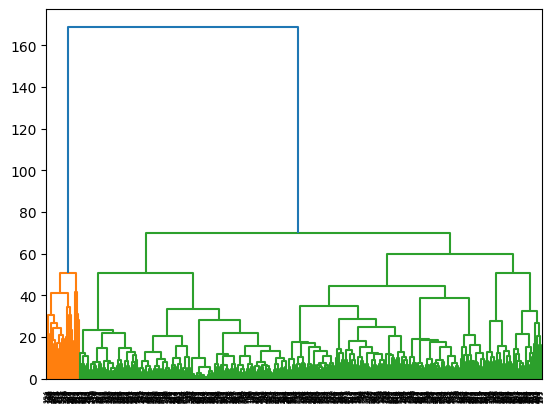

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# display with scipy
linkage_data = linkage(data, method='ward', metric='euclidean')
dendrogram(linkage_data)
print(linkage_data)
plt.show()

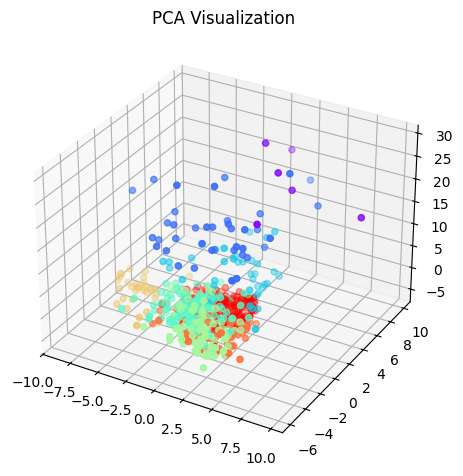

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

n=8
hierarchical_cluster = AgglomerativeClustering(n_clusters=n, linkage='ward')
labels = hierarchical_cluster.fit_predict(data)
cluster_dict = {"cluster": labels}
out_df = name_df.hstack(pl.from_dict(cluster_dict))
out_df = out_df.select(
    pl.col("name"),
    pl.col("cluster"),
).sort(pl.col("cluster"), pl.col("name"))
out_df.write_csv(f"stat-hierarchial-{n}n.csv")

combined_df = name_df.join(
    out_df,
    on=["name"],
    how="inner"
)

cluster_center_df = pl.DataFrame()
clusters = pl.from_dict(cluster_dict)["cluster"].unique().to_list()
for cluster in clusters:
    cluster_df = combined_df.filter(
        pl.col("cluster") == cluster
    ).drop(
        pl.col("cluster")
    )
    cluster_means = cluster_df.drop("name").mean().to_numpy()
    cluster_min, cluster_min_name = 10000000000000000, ""
    for row in cluster_df.rows():
        name = row[-1]
        row_data = row[:-1]
        row_np = np.array(row_data)
        diff = cluster_means - row_np
        dmean = diff.mean()
        if dmean < cluster_min:
            cluster_min_name = name
            cluster_min = dmean
    cluster_center_dict = {"name": cluster_min_name, "cluter": cluster}
    cluster_df = pl.from_dict(cluster_center_dict)
    cluster_center_df = cluster_center_df.vstack(cluster_df)
cluster_center_df.write_csv(f"cluster-centers-hierarchial-{n}n.csv")

from sklearn.decomposition import PCA

n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(data) 
names = name_df["name"].to_list()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_pca[:, 2], X_pca[:, 1], X_pca[:, 0], c=labels, cmap=plt.cm.rainbow)

plt.title("PCA Visualization")
plt.tight_layout()
plt.show()